<a href="https://colab.research.google.com/github/zulfanaliy/SKJ/blob/Example/CodeExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
from skimage.io import imread, imshow
from skimage.transform import rescale
import skimage
import bitarray
import matplotlib.pyplot as plt

In [ ]:
Scripts = ""

def TextToString(txt):
    with open (txt, "r") as file:
        data=file.readlines()
        script = ""
        for x in data[0:]:
            x = x.replace('"','').replace("\n"," \n ").split(' ')
            script += " ".join(x[0:])
        return script

Scripts += TextToString("Moon-Knight-S01E01-The Goldfish Problem.txt")
Scripts += TextToString("Moon-Knight-S01E02-Summon the Suit.txt")
Scripts += TextToString("Moon-Knight-S01E03-The Friendly Type.txt")
Scripts += TextToString("Moon-Knight-S01E04-The Tomb.txt")
Scripts += TextToString("Moon-Knight-S01E05-Asylum.txt")
Scripts += TextToString("Moon-Knight-S01E06-Gods and Monsters.txt")

print(Scripts[:500])

1 
 000327,417 -- 000329,667 
 Pagi, Gus, sobatku yang bersirip satu. 
  
 2 
 000330,250 -- 000333,708 
 Halo, Bu. Ini aku. Cuma mau mengabari. 
  
 3 
 000333,792 -- 000337,625 
 Aku sudah terima kartu posnya, 
 sedang aku pasang di akuarium Gus. 
  
 4 
 000337,708 -- 000340,542 
 Ya, bagus sekali. Namun, dia kesal. 
  
 5 
 000340,625 -- 000343,792 
 Dia heran kenapa aku tidak pernah 
 mengajaknya pergi. 
  
 6 
 000343,875 -- 000345,167 
 Mungkin nanti, ya 
  
 7 
 000345,250 -- 000348,417 


Image is 1600 by 890 pixels with 3 color channels


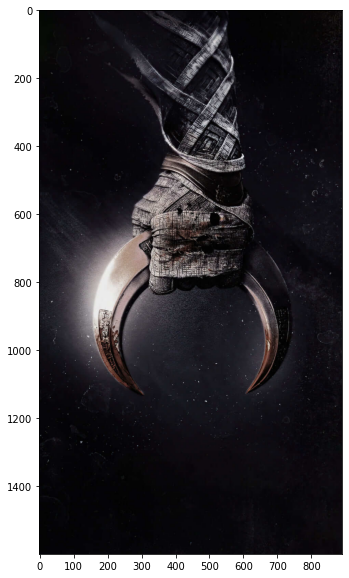

In [ ]:
image = imread("moon-knight-weapons.jpg")

plt.figure(figsize=(10, 10))
plt.imshow(image)

print("Image is "+str(image.shape[0])+" by "+str(image.shape[1])+" pixels with "+str(image.shape[2])+" color channels")

In [ ]:
def MessageToBits(message):
    #tag message (and pad w/ spaces till 10 characters)
    tag = "{:<10}".format(str(len(message)*8))
    message = tag+message
    #convert to bits
    code = bitarray.bitarray()
    code.frombytes(message.encode('utf-8'))
    code = "".join(['1' if x == True else '0' for x in code.tolist()])
    return code

In [ ]:
print(MessageToBits(Scripts))

0011000100110111001101100011010100111001001100010011001000100000001000000010000000110001001000000000101000100000001100000011000000110000001100110011001000110111001011000011010000110001001101110010000000101101001011010010000000110000001100000011000000110011001100100011100100101100001101100011011000110111001000000000101000100000010100000110000101100111011010010010110000100000010001110111010101110011001011000010000001110011011011110110001001100001011101000110101101110101001000000111100101100001011011100110011100100000011000100110010101110010011100110110100101110010011010010111000000100000011100110110000101110100011101010010111000100000000010100010000000100000000010100010000000110010001000000000101000100000001100000011000000110000001100110011001100110000001011000011001000110101001100000010000000101101001011010010000000110000001100000011000000110011001100110011001100101100001101110011000000111000001000000000101000100000010010000110000101101100011011110010110000100000010000100111010100101110

In [ ]:
def CheckBitSize(img, message):
    h = img.shape[0]
    w = img.shape[1]
    try:
        c = img.shape[2]
    except:
        c = 1
    image_max_size = h*w*c*2
    string_size = len(message)
    print("Message is "+str(string_size/8000)+" KB and image can fit "+str(image_max_size/8000)+" KB of data")
    if string_size > image_max_size:
        print("Message is too big to be encoded in image")
        return False
    else:
        print("Image can be encoded with message. Proceed")
        return True

CheckBitSize(image, MessageToBits(Scripts))

Message is 220.749 KB and image can fit 1068.0 KB of data
Image can be encoded with message. Proceed


True

In [ ]:
%%time
def EncodeImage(img, message):
    code = MessageToBits(message)
    if CheckBitSize(img, code):
        shape = img.shape
        img = img.flatten()
        code = list(code)
        code_len = len(code)
        for i,x in enumerate(img):
            if i*2 <code_len:
                zbits = list('{0:08b}'.format(x))[:6]+code[i*2:i*2+2]
                img[i] = int("".join(zbits), 2)
            else:
                return img.reshape(shape)
        return img.reshape(shape)

encoded_image = EncodeImage(image, Scripts)

Message is 220.749 KB and image can fit 1068.0 KB of data
Image can be encoded with message. Proceed
CPU times: total: 1.66 s
Wall time: 1.66 s


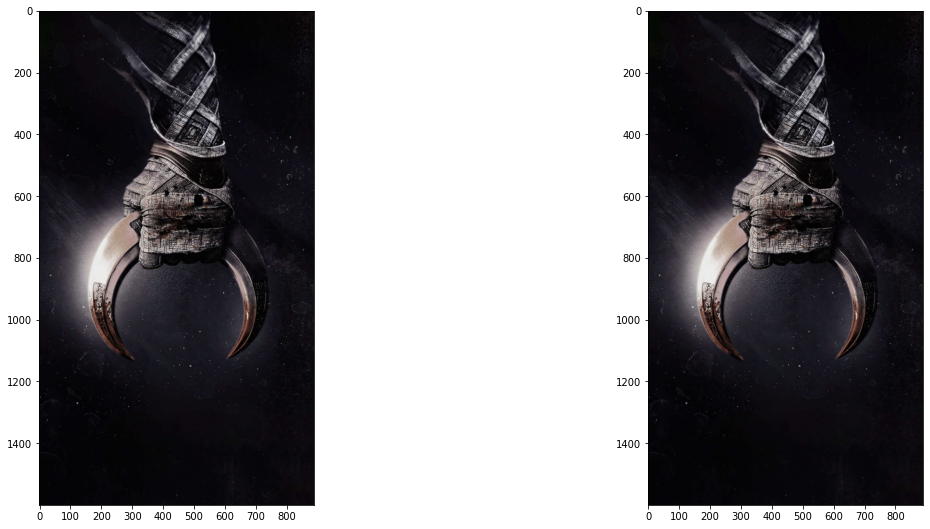

In [ ]:
def CompareTwoImages(img1,img2):
    fig=plt.figure(figsize=(20, 20))
    fig.add_subplot(2, 2, 1)
    plt.imshow(img1)
    fig.add_subplot(2, 2, 2)
    plt.imshow(img2)
    plt.show()
CompareTwoImages(image, encoded_image)

In [ ]:
print(image[200][200])
print(encoded_image[200][200])

[13 12 17]
[13 15 18]


In [ ]:
%%time
def DecodeImage(img):
    bit_message = ""
    bit_count = 0
    bit_length = 200
    for i,x in enumerate(img):
        for j,y in enumerate(x):
            for k,z in enumerate(y):
                zbits = '{0:08b}'.format(z)
                bit_message += zbits[-2:]
                bit_count += 2
                if bit_count == 80:
                    try:
                        decoded_tag = bitarray.bitarray(bit_message).tobytes().decode('utf-8')
                        bit_length = int(decoded_tag)+80
                        bit_message = ""
                    except:
                        print("Image does not have decode tag. Image is either not encoded or, at least, not encoded in a way this decoder recognizes")
                        return
                elif bit_count >= bit_length:
                    return bitarray.bitarray(bit_message).tobytes().decode('utf-8')

decoded_message = DecodeImage(encoded_image)
print(decoded_message[:500])

1 
 000327,417 -- 000329,667 
 Pagi, Gus, sobatku yang bersirip satu. 
  
 2 
 000330,250 -- 000333,708 
 Halo, Bu. Ini aku. Cuma mau mengabari. 
  
 3 
 000333,792 -- 000337,625 
 Aku sudah terima kartu posnya, 
 sedang aku pasang di akuarium Gus. 
  
 4 
 000337,708 -- 000340,542 
 Ya, bagus sekali. Namun, dia kesal. 
  
 5 
 000340,625 -- 000343,792 
 Dia heran kenapa aku tidak pernah 
 mengajaknya pergi. 
  
 6 
 000343,875 -- 000345,167 
 Mungkin nanti, ya 
  
 7 
 000345,250 -- 000348,417 
CPU times: total: 1.36 s
Wall time: 1.35 s


In [ ]:
print(decoded_message == Scripts)

True


In [ ]:
skimage.io.imsave("Image_With_Scripts.jpg", encoded_image)